## IMPORTANT NOTE!!!
Iso recording is ignored here due to a large amount of 60Hz noise!
Could try to notch filter with spyking circus and re-run! Might interfere with ripple detection though if I have to remove 60Hz harmonics!

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
# sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # For mac laptop
sys.path.extend(['/data/GitHub/NeuroPy'])  # for linux
plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch, ProcessData
from neuropy.io.spykingcircusio import SpykingCircusIO

In [2]:
sess = ProcessData("/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/")
print(sess.recinfo)

filename: /data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/continuous_combined_sub.xml 
# channels: 32
sampling rate: 30000
lfp Srate (downsampled): 1250



In [3]:
print(sess.eegfile)

duration: 15598.39 seconds 
duration: 4.33 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [4]:
signal = sess.eegfile.get_signal()

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs

art_epochs_source_file = sess.filePrefix.with_suffix('.artifact.npy')

if art_epochs_source_file.is_file():
    art_epochs = Epoch(epochs=None, file=art_epochs_source_file)
    print('pre-existing epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=2, merge=6)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_source_file)


        

pre-existing epochs file loaded


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Sanity check

In [6]:
# from copy import deepcopy

# # Manually fix missing noise epoch in middle!
# art_list = [[1316, 1410.5]]
# art_epochs_fix = deepcopy(art_epochs)
# for (start, stop) in art_list:
#     art_epochs_fix = art_epochs_fix.add_epoch_manually(start, stop)

# sess.recinfo.write_epochs(epochs=art_epochs_fix, ext='art')
# art_epochs_fix.save(art_epochs_source_file)

In [7]:
# art_epochs_fix.to_dataframe()

<Axes: >

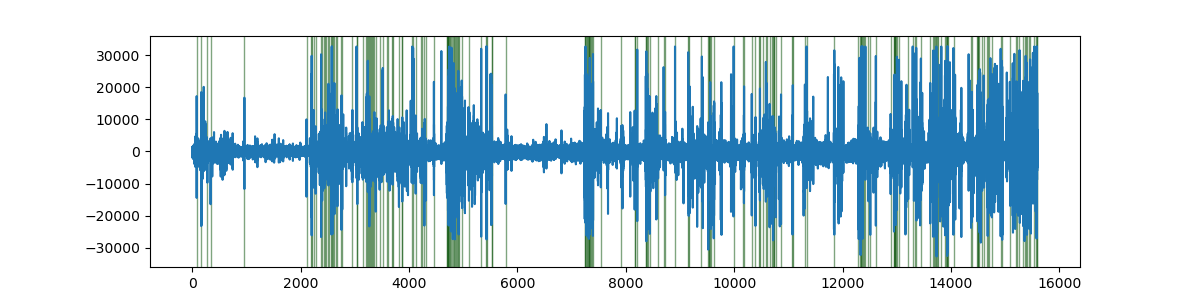

In [8]:
%matplotlib widget
from neuropy.plotting.signals import plot_signal_w_epochs
_, ax = plt.subplots(figsize=(12, 3))
plot_signal_w_epochs(signal, channel=21, epochs=art_epochs, ax=ax)

In [9]:
df = art_epochs.to_dataframe()
print(f'Total artifact duration = {df.duration.sum()/60:0.000g} minutes')
df.sort_values(by=['duration']).tail(5)

Total artifact duration = 8 minutes


,start,stop,label,duration
16,2567.0800,2585.8056,,18.7256
144,13729.2856,13749.2640,,19.9784
55,4717.4264,4742.9400,,25.5136
69,7254.0680,7287.1776,,33.1096
56,4749.6488,4822.5192,,72.8704


In [10]:
# make easy to track in neuroscope
df['start_min'] = np.floor(df.start/60)
df['start_sec'] = (df.start/60 - df['start_min'])*60
df['stop_min'] = np.floor(df.stop/60)
df['stop_sec'] = (df.stop/60 - df['stop_min'])*60

In [11]:
def add_epoch_buffer(epoch_df: pd.DataFrame, buffer_sec: float or int or tuple or list):
    """Extend each epoch by buffer_sec before/after start/stop of each epoch"""
    if type(buffer_sec) in [int, float]:
        buffer_sec = (buffer_sec, buffer_sec)
    else:
        assert len(buffer_sec) == 2
        
    epoch_df['start'] -= buffer_sec[0]
    epoch_df['stop'] += buffer_sec[1]

In [12]:
add_epoch_buffer(art_epochs._epochs, 0.2)
sess.recinfo.write_epochs(art_epochs, 'art')
art_epochs._epochs

,start,stop,label
0,80.5800,81.0888,
1,165.9040,166.4824,
2,278.4368,278.8584,
3,337.4288,338.1656,
4,961.4712,961.8856,
...,...,...,...
173,15447.8720,15448.5152,
174,15534.2832,15534.8912,
175,15559.4112,15560.0776,
176,15576.0440,15580.4360,


### Add in injection time

In [13]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2025-04-17 09:12:20.181000-04:00
start time = 2025-04-17 11:32:20.249000-04:00
start time = 2025-04-17 11:37:44.838000-04:00
start time = 2025-04-17 12:05:55.795000-04:00
start time = 2025-04-17 13:18:56.229000-04:00
start time = 2025-04-17 13:18:58.419000-04:00
start time = 2025-04-17 13:20:39.359000-04:00
start time = 2025-04-17 13:40:05.752000-04:00
start time = 2025-04-17 14:07:36.912000-04:00
start time = 2025-04-17 14:32:12.632000-04:00
start time = 2025-04-17 14:50:37.738000-04:00
start time = 2025-04-17 14:57:52.224000-04:00
start time = 2025-04-17 15:43:44.792000-04:00
start time = 2025-04-17 16:06:37.752000-04:00
start time = 2025-04-17 16:10:43.160000-04:00
start time = 2025-04-17 16:21:37.175000-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2025-04-17 09:12:20.181000-04:00,start,0,0.000000,0,0.0000
1,0,2025-04-17 09:48:30.028433333-04:00,stop,65095423,2169.847433,2712309,2169.8472
2,1,2025-04-17 11:32:20.249000-04:00,start,65095424,2169.847467,2712310,2169.8480
3,1,2025-04-17 11:37:20.912433333-04:00,stop,74115327,2470.510900,3088138,2470.5104
4,2,2025-04-17 11:37:44.838000-04:00,start,74115328,2470.510933,3088139,2470.5112
5,2,2025-04-17 12:05:49.872633333-04:00,stop,124666367,4155.545567,5194431,4155.5448
6,3,2025-04-17 12:05:55.795000-04:00,start,124666368,4155.545600,5194432,4155.5456
7,3,2025-04-17 12:09:46.237633333-04:00,stop,131579647,4385.988233,5482485,4385.9880
8,4,2025-04-17 13:18:56.229000-04:00,start,131579648,4385.988267,5482486,4385.9888
9,4,2025-04-17 13:18:57.304166667-04:00,stop,131611903,4387.063433,5483829,4387.0632


In [14]:
# start_time = sync_df.Datetime[0]
# tiso_start_sec = (iso_start - start_time).total_seconds()
# rec_times_sec = (sync_df.Datetime - start_time).dt.total_seconds()
# rec_times_sec
# tiso_start_sync_sec = np.interp(tiso_start_sec, rec_times_sec, sync_df.eeg_time)

# starts = [0, tiso_start_sync_sec]
# stops = [tiso_start_sync_sec - 1/sess.eegfile.sampling_rate, sess.eegfile.duration]
# iso_epochs = Epoch(pd.DataFrame({"start": starts, "stop": stops, "label": ["PRE", "POST"]}))
# sess.recinfo.write_epochs(iso_epochs, 'iso')
# sess.iso_epochs = iso_epochs
# sess.iso_epochs.save(sess.filePrefix.with_suffix('.iso.npy'))
# iso_epochs

### Tag behavioral epochs

In [15]:
pre2_start = pd.Timestamp(year=2025, month=4, day=17, hour=11, minute=32, second=20, tz='America/Detroit')
maze_start = pd.Timestamp(year=2025, month=4, day=17, hour=11, minute=37, second=45, tz='America/Detroit')
iso_start = pd.Timestamp(year=2025, month=4, day=17, hour=12, minute=15, tz='America/Detroit')
rorr = pd.Timestamp(year=2025, month=4, day=17, hour=13, minute=23, tz='America/Detroit')
maze2_start = pd.Timestamp(year=2025, month=4, day=17, hour=14, minute=7, second=15, tz='America/Detroit')

start_time = sync_df.Datetime[0]
rec_times_sec = (sync_df.Datetime - start_time).dt.total_seconds()
starts = [0]
for evt in [pre2_start, maze_start, iso_start, rorr, maze2_start]:
    evt_sec = (evt - start_time).total_seconds()
    teventsync_sec = np.interp(evt_sec, rec_times_sec, sync_df.eeg_time)
    starts.append(teventsync_sec)

paradigm_df = pd.DataFrame({"start": starts, 
                            "stop": np.hstack((np.array(starts[1:]) + 1/sess.eegfile.sampling_rate, sess.eegfile.duration)),
                            "label": ["PRE", "PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"]})
sess.paradigm_epochs = Epoch(paradigm_df)
sess.paradigm_epochs.save(sess.filePrefix.with_suffix(".paradigm.npy"))
sess.recinfo.write_epochs(sess.paradigm_epochs, "beh")
sess.paradigm_epochs

/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/continuous_combined_sub.paradigm.npy saved


6 epochs
Snippet: 
          start         stop              label
0     0.000000  2169.848800                PRE
1  2169.848000  2470.674000               PRE2
2  2470.673200  4385.988860               MAZE
3  4385.988060  4613.149662  RECOVERY_PRE_RORR
4  4613.148862  7156.932804           RECOVERY

## Define probe group

/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/continuous_combined_sub.probegroup.npy saved


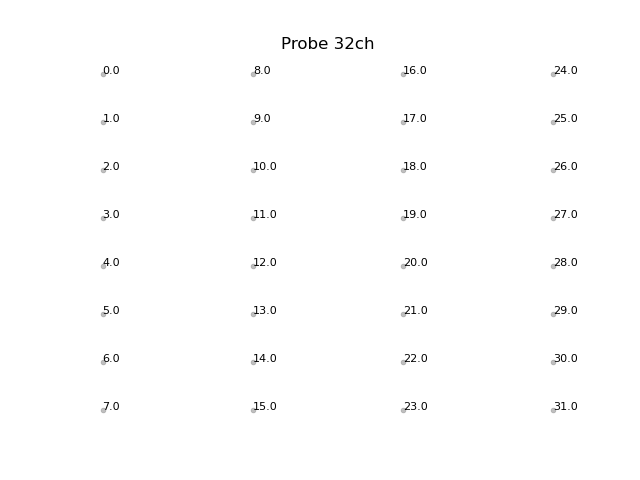

In [16]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting.probe import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=4, contacts_per_column=8, xpitch=500,
                   ypitch=-20, channel_id=np.arange(0, 32, 1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Process spikes

Awesome, all my work from yesterday is garbage. For some reason phy is not saving the updated clusters and now I can't load the new data in.

In [17]:
from neuropy.io.phyio import PhyIO
sess.phy = PhyIO(dirname=sorted(sess.basepath.glob("**/*.GUI"))[0])

id column does not exist in cluster_info.tsv. Using cluster_id column instead.
error loading clu_id 128
error loading clu_id 134


In [18]:
print(f'last spike time = {np.max([a.max() for a in sess.phy.spiketrains[:-2]])}')
print(f'recording duration = {sess.eegfile.duration}')

last spike time = 15598.372433333334
recording duration = 15598.3872


In [19]:
type(sess.phy.cluster_info['q'].values)

numpy.ndarray

In [20]:
from neuropy.core.neurons import Neurons
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, sampling_rate=1,
                      neuron_type=sess.phy.cluster_info['q'].values)
# sess.all_neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, sampling_rate=1,
#                       neuron_type=sess.phy.cluster_info['q'])

# Now trim out PRE since probe moved after that
sess.neurons = sess.neurons.time_slice(sess.paradigm_epochs["PRE2"].starts[0], sess.paradigm_epochs["reMAZE"].stops[0])

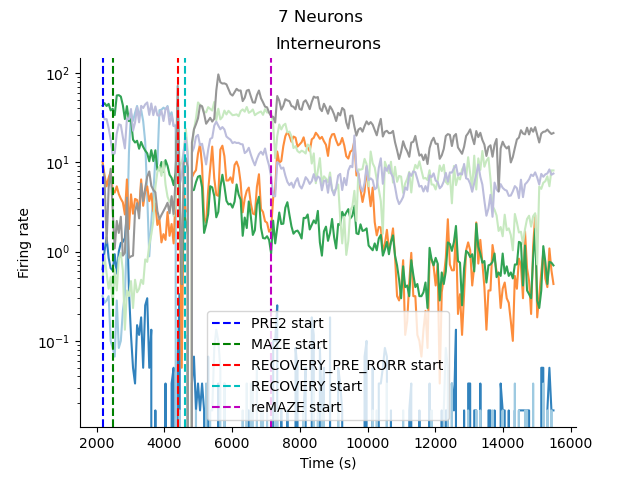

In [21]:
from neuropy.plotting.spikes import plot_firing_rate
plot_firing_rate(sess.neurons.get_neuron_type([8]))
ax = plt.gca()

hline = []
for epoch, color in zip(["PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"], ['b', 'g', 'r', 'c', 'm', 'y']):
    epoch_plot = sess.paradigm_epochs[epoch]
    h = ax.axvline(epoch_plot.starts[0], linestyle='--', color=color, label=f"{epoch} start")

sns.despine(ax=ax)
ax.set_title("Interneurons")
plt.legend()

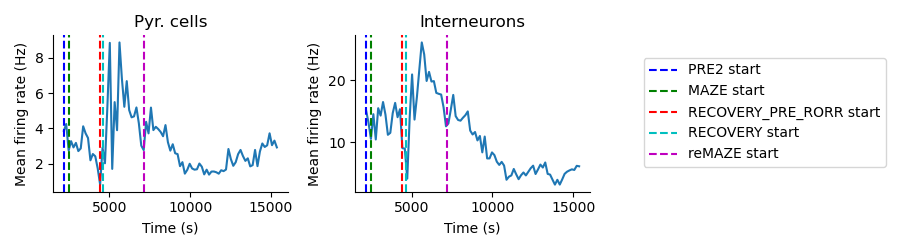

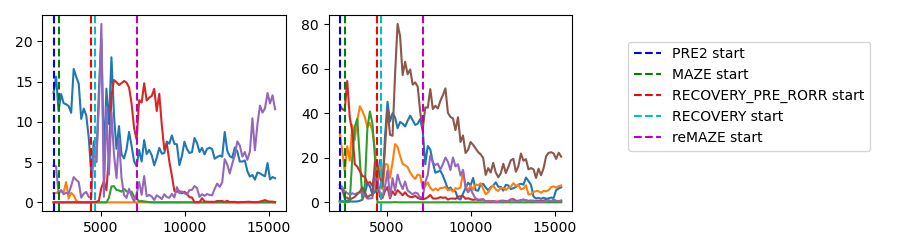

In [31]:
bin_size = 60 * 2.5
ntype = "pyr"

figfr, axs = plt.subplots(1, 2, figsize=(9, 2.5), layout='tight')
figall, axalls = plt.subplots(1, 2, figsize=(9, 2.5), layout='tight')

for ax, axall, ntype in zip(axs, axalls, ["pyr", "int"]):
    assert ntype in ["pyr", "int"]
    neurons_by_type = sess.neurons.get_neuron_type([1, 2, 3]) if ntype == "pyr" else sess.neurons.get_neuron_type([8])
    if ntype == "pyr":
        good_ids = neurons_by_type.neuron_ids[(neurons_by_type.firing_rate < 8) & (neurons_by_type.firing_rate > 0)]
    elif ntype == "int":
        good_ids = neurons_by_type.neuron_ids[(neurons_by_type.firing_rate > 2)]
    neurons_by_type.neuron_slice(neuron_ids=good_ids)
    spikes_use = neurons_by_type.neuron_slice(neuron_ids=good_ids).get_binned_spiketrains(bin_size=bin_size)
    
    ax.plot(spikes_use.time, (spikes_use.spike_counts / bin_size).mean(axis=0))
    axall.plot(spikes_use.time, (spikes_use.spike_counts.T / bin_size))
    
    hline = []
    for epoch, color in zip(["PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"], ['b', 'g', 'r', 'c', 'm', 'y']):
        epoch_plot = sess.paradigm_epochs[epoch]
        h = ax.axvline(epoch_plot.starts[0], linestyle='--', color=color, label=f"{epoch} start")
        axall.axvline(epoch_plot.starts[0], linestyle='--', color=color, label=f"{epoch} start")
    
    sns.despine(ax=ax)
    ax.set_title("Pyr. cells" if ntype == "pyr" else "Interneurons")
    ax.set_ylabel('Mean firing rate (Hz)')
    ax.set_xlabel('Time (s)')

axs[1].legend(bbox_to_anchor=(1.2, 0.9))
axalls[1].legend(bbox_to_anchor=(1.2, 0.9))

figfr.savefig(plot_dir / "mean_FR_over_time.pdf")

In [177]:
spikes_use = neurons_by_type.neuron_slice(neuron_ids=good_ids).get_binned_spiketrains(bin_size=0.05)

In [179]:
spikes_use.spike_counts.max(axis=1) / 0.05

array([380., 680., 440.])

In [ ]:
_, ax = 

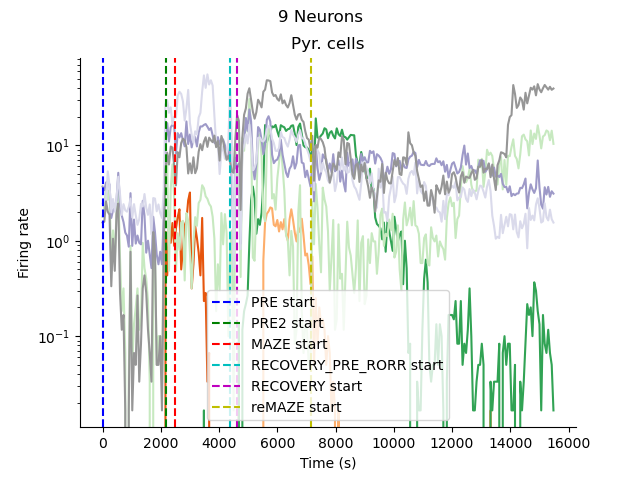

In [32]:
from neuropy.plotting.spikes import plot_firing_rate
plot_firing_rate(sess.neurons.get_neuron_type([1, 2, 3]))
ax = plt.gca()

hline = []
for epoch, color in zip(["PRE", "PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"], ['b', 'g', 'r', 'c', 'm', 'y']):
    epoch_plot = sess.paradigm_epochs[epoch]
    h = ax.axvline(epoch_plot.starts[0], linestyle='--', color=color, label=f"{epoch} start")

sns.despine(ax=ax)
ax.set_title("Pyr. cells")
plt.legend()

In [33]:
fr_df_all = []
for ntype in ["pyr", "int"]:
    if ntype == "pyr":
        neurons_use = sess.neurons.get_neuron_type([1, 2, 3])
    elif ntype == "int":
        neurons_use = sess.neurons.get_neuron_type([8])
    else:
        assert False, 'ntype must be either "int" or "pyr"'
        
    for epoch_name in ["PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"]:
        neurons_by_epoch = neurons_use.time_slice(sess.paradigm_epochs[epoch_name].starts[0], sess.paradigm_epochs[epoch_name].stops[0])
        fr_df_all.append(pd.DataFrame({"nid": neurons_by_epoch.neuron_ids, "frate": neurons_by_epoch.firing_rate, "ntype": ntype, "block": epoch_name}))

fr_df_all = pd.concat(fr_df_all, axis=0, ignore_index=True)


In [ ]:
df_use.groupby("nid").max(numeric_only=True) < 10

In [ ]:
df_use[[nid in [8, 16, 17, 19] for nid in df_use.nid]]

<Axes: xlabel='block', ylabel='frate'>

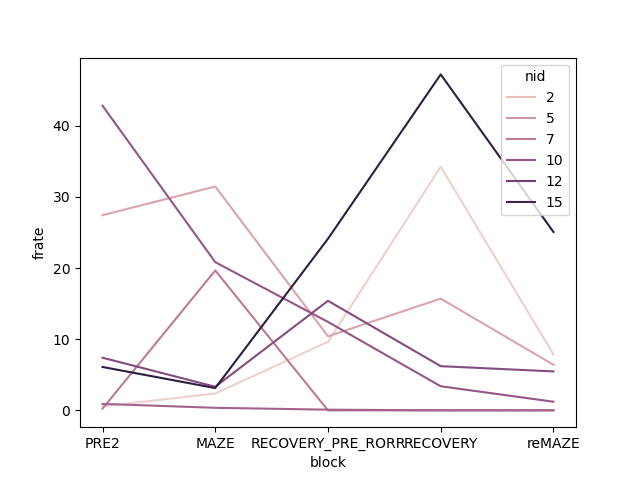

In [58]:
_, ax = plt.subplots()
df_use = fr_df_all[fr_df_all.ntype == "int"]
df_use2 = df_use[[nid in [8, 16, 17, 19] for nid in df_use.nid]]  # trim out misclassified neurons
# sns.stripplot(data=df_use, x="block", y="frate", ax=ax)
sns.lineplot(data=df_use, x="block", y="frate", hue="nid", ax=ax)

## Look at behavior
Animal runs pretty consistently throughout session

In [155]:
from neuropy.io.optitrackio import OptitrackIO
opti = OptitrackIO(sess.basepath / "5_track2")


/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 02.08.31 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 02.32.15 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 02.50.41 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 02.57.53 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 03.41.46 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 03.43.47 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 04.06.39 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 04.10.46 PM.csv
/data2/Anesthesia/Recording_Rats/Peach/2025_04_17_TrackAnesTrack/5_track2/Take 2025-04-17 04.21.38 PM.csv


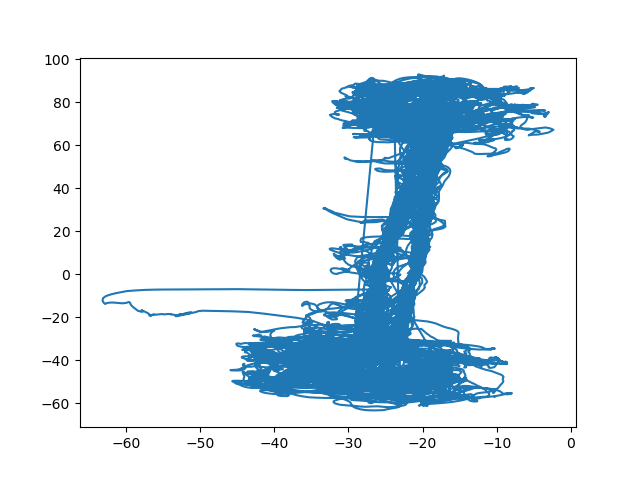

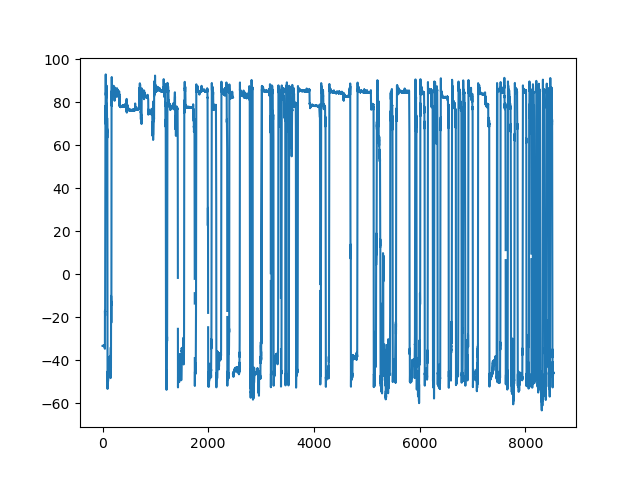

In [157]:
pos = opti.to_position()

_, ax = plt.subplots()
ax.plot(pos.x, pos.z)

_, ax = plt.subplots()
ax.plot(pos.time, pos.z)

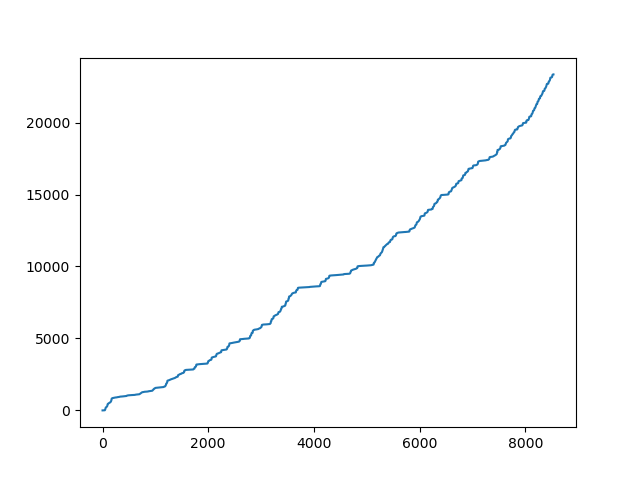

In [165]:
dist = np.abs(np.diff(pos.z))
dist[np.isnan(dist)] = 0
_, ax = plt.subplots()
ax.plot(pos.time[:-1], np.cumsum(dist))

Calculate MUA

In [ ]:
sess.mua = sess.pyr_neurons.get_mua(bin_size=0.05)

Import curated ripple data

In [ ]:
from neuropy.core.epoch import Epoch
sess.ripple = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple_curated.npy'))

In [ ]:
a = sess.ripple.to_dataframe()

# Detect ripples and theta

NRK - try running this with a) more aggressive artifact filter and b) selecting a better ripple channel and c) adding in a sharpwave channel too  
  
Also, need to run spyking-circus with median filter AND on different session - maybe less noisy/better with different preamp?

In [ ]:
from neuropy.utils import signal_process
pyr_ch = 21
# sw_ch = 12
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
# ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)

In [ ]:
import scipy.stats as stats
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
# zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

#### Ripples

In [37]:
from neuropy.analyses import oscillations

pyr_ch = 21

if sess.filePrefix.with_suffix('.ripple.npy').is_file():
    ripple_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple.npy'))
    ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
    sess.ripple_epochs = ripple_epochs
    print('Pre-existing ripple epochs npy file loaded')
else:    
    ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(4, None), 
                                                      ripple_channel=pyr_ch,
                                                      ignore_epochs=art_epochs, mindur=0.05)
    ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
    sess.ripple_epochs = ripple_epochs
    sess.recinfo.write_epochs(sess.ripple_epochs, 'swr')
    sess.ripple_epochs.save(sess.filePrefix.with_suffix('.ripple.npy'))

Pre-existing ripple epochs npy file loaded


### Ripple rate appears to go down following iso, especially during reMAZE
Durations also go down.

In [57]:
sess.ripple_epochs = sess.ripple_epochs.add_column("rpl duration", sess.ripple_epochs.stops - sess.ripple_epochs.starts)

rpl_rate, rpl_dur = [], []
blk_names = ["PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"]
for epoch_name in blk_names:
    
    rpl_epoch_use = sess.ripple_epochs.time_slice(sess.paradigm_epochs[epoch_name].starts[0], sess.paradigm_epochs[epoch_name].stops[0])
    dur = rpl_epoch_use.stops[-1] - rpl_epoch_use.starts[0]
    nrip = rpl_epoch_use.n_epochs
    rpl_rate.append(nrip / dur)
    rpl_dur.append(rpl_epoch_use.to_dataframe()["rpl duration"].mean())

rpl_rate_df = pd.DataFrame({"block": blk_names, "rpl_rate": rpl_rate, "rpl_duration": rpl_dur})
rpl_rate_df
                            
    

,block,rpl_rate,rpl_duration
0,PRE2,0.365457,0.139756
1,MAZE,0.195604,0.143341
2,RECOVERY_PRE_RORR,0.029446,0.086400
3,RECOVERY,0.134621,0.119499
4,reMAZE,0.068203,0.114813


In [195]:
rpl_rate_binned.spike_counts

array([[ 6.,  7., 19.,  9.,  3.,  1., 11.,  1., 12., 32.,  0.,  0.,  0.,
         0.,  0.,  0.,  6.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  6.,  6.,  0.,  0.,  0.,  0.,  4., 36., 70., 37.,
        86., 50., 39.,  5., 34., 26., 55.,  7., 30., 64., 31., 22., 20.,
        14., 27., 18., 62., 56., 42., 72., 72., 58., 42., 35., 57., 27.,
        17., 22.,  4., 27., 34., 27., 39., 12.,  2.,  5.,  0.,  2.,  0.,
        16.,  0.,  5.,  8., 38., 32., 46., 36., 15., 13., 32., 16., 31.,
        50., 42., 28., 34., 42., 31., 17., 25., 14.,  7., 16., 11., 10.,
        12., 16., 11., 14., 21.,  7., 13.,  0.,  9., 18., 12., 12.,  4.,
         8.,  8.,  4., 12., 10., 51., 22., 14., 10.,  9., 11., 12.,  5.,
        11.,  9., 11., 10.,  3.,  4., 11.,  2.,  3.,  9., 15.,  2., 28.,
         0.,  6.,  3., 16.,  1., 20.,  6.,  3., 11.,  7.,  4., 19., 18.,
         1.,  0., 13., 12., 28.,  2.,  0.,  0.,  2.,  8., 33.,  8.,  1.,
        12.,  2.,  2., 14., 10.,  2.,  7.,  8., 18.

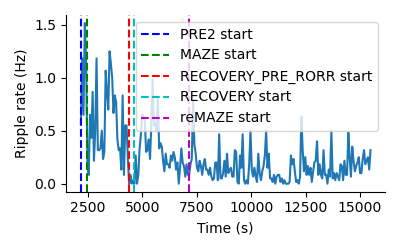

In [211]:
times, rpl_bool = sess.ripple_epochs.time_slice(sess.paradigm_epochs["PRE2"].starts[0], sess.paradigm_epochs["reMAZE"].stops[0]).to_point_process(bin_size=0.05)
rpls = Neurons([times[rpl_bool]], t_start=sess.paradigm_epochs["PRE2"].starts[0], t_stop = times[-1], sampling_rate=1/0.05)
rpl_rate_binned = rpls.get_binned_spiketrains(bin_size=60)
fig_rip_rate, axs = plt.subplots(1, 1, figsize=(4, 2.5), layout='tight')
ax=axs
ax.plot(rpl_rate_binned.time, rpl_rate_binned.spike_counts.squeeze() / 60)

for epoch, color in zip(["PRE2", "MAZE", "RECOVERY_PRE_RORR", "RECOVERY", "reMAZE"], ['b', 'g', 'r', 'c', 'm', 'y']):
    epoch_plot = sess.paradigm_epochs[epoch]
    h = ax.axvline(epoch_plot.starts[0], linestyle='--', color=color, label=f"{epoch} start")

plt.legend()
sns.despine(ax=ax)
ax.set_ylabel("Ripple rate (Hz)")
ax.set_xlabel("Time (s)")

fig_rip_rate.savefig(plot_dir / "ripple_rate_v_time.pdf")

In [50]:
sess.ripple_epochs = sess.ripple_epochs.add_column("duration", sess.ripple_epochs.stops - sess.ripple_epochs.starts)
sess.ripple_epochs

1454 epochs
Snippet: 
      start     stop  peak_time  peak_power  duration label
0  51.6152  51.6808    51.6480    7.337862    0.0656      
1  54.2976  54.4240    54.3528    6.472039    0.1264      
2  56.0632  56.1720    56.1264    4.677550    0.1088      
3  60.4312  60.5256    60.4960    5.211467    0.0944      
4  80.7184  80.7800    80.7792   11.025797    0.0616      

In [56]:
rpl_epoch_use["rpl duration"]

0 epochs
Snippet: 
 Empty DataFrame
Columns: [start, stop, peak_time, peak_power, rpl duration, label]
Index: []

In [45]:
dur = rpl_epoch_use.stops[-1] - rpl_epoch_use.starts[0]
nrip = rpl_epoch_use.n_epochs
rpl_rate = nrip / dur
rpl_rate

0.06820251441520739

#### Sharp-wave

In [ ]:
if sess.filePrefix.with_suffix('.sharpwave.npy').is_file():
    sw_epochs = Epoch(epochs=None, file = sess.filePrefix.with_suffix('.sharpwave.npy'))
    print('Pre-existing sharpwave epochs npy file loaded')
else:
    sw_epochs = oscillations.detect_sharpwave_epochs(signal, sess.prbgrp, thresh=(4, None),
                                                 edge_cutoff=1.5, ignore_epochs=art_epochs,
                                                 sharpwave_channel=sw_ch)
    sess.recinfo.write_epochs(sw_epochs, 'swv')
    sess.sw_epochs = sw_epochs
    sess.sw_epochs.save(sess.filePrefix.with_suffix('.sharpwave.npy'))

In [ ]:
ripple_epochs

In [ ]:
sw_epochs

In [ ]:
rpl_df = ripple_epochs.to_dataframe()
rpl_df["Session"] = "Saline1"

rpl_epochs_psi = Epoch(epochs=None, file=sess.filePrefix.parent.parent / '2022_02_17_psilocybin/Finn_psilocybin_denoised.ripple.npy')
rpl_df_psi = rpl_epochs_psi.to_dataframe()
rpl_df_psi["Session"] = "Psilocybin"

df_comb = pd.concat((rpl_df, rpl_df_psi), axis=0).reset_index()

inject_epochs_psi = Epoch(epochs=None, file=sess.filePrefix.parent.parent / '2022_02_17_psilocybin/Finn_psilocybin_denoised.injection.npy')

In [ ]:
time_bins_min = 30  

inj_time_sal = inject_epochs["PRE"].stops[0]
inj_time_psi = inject_epochs_psi["PRE"].stops[0]

df_comb.loc[(df_comb["Session"] == "Saline1") & (df_comb["peak_time"] < inj_time_sal), "Epoch"] = "PRE"
df_comb.loc[(df_comb["Session"] == "Psilocybin") & (df_comb["peak_time"] < inj_time_psi), "Epoch"] = "PRE"

bins_sal = np.arange(inject_epochs["POST"].starts[0], inject_epochs["POST"].stops[0], time_bins_min * 60)
bins_psi = np.arange(inject_epochs_psi["POST"].starts[0], inject_epochs_psi["POST"].stops[0], time_bins_min * 60)

for idb, (sal_start, sal_stop) in enumerate(zip(bins_sal[:-1], bins_sal[1:])):
    label = f"{idb * time_bins_min:.0f}-{(idb + 1) * time_bins_min:.0f} min post"
    df_comb.loc[(df_comb["Session"] == "Saline1") & (df_comb["peak_time"] > sal_start) & (df_comb["peak_time"] <= sal_stop), "Epoch"] = label
for idb, (psi_start, psi_stop) in enumerate(zip(bins_psi[:-1], bins_psi[1:])):
    label = f"{idb * time_bins_min:.0f}-{(idb + 1) * time_bins_min:.0f} min post"
    df_comb.loc[(df_comb["Session"] == "Psilocybin") & (df_comb["peak_time"] > psi_start) & (df_comb["peak_time"] <= psi_stop), "Epoch"] = label

In [ ]:
inject_epochs_psi["POST"].stops[0]

In [ ]:
bins_psi

In [ ]:
df_comb[df_comb.Session == "Psilocybin"].Epoch.unique()

In [ ]:
_, ax = plt.subplots(3, 1, figsize=(9, 8), sharey=True)


sns.boxplot(data=df_comb, x="Epoch", y="peak_power", hue="Session", dodge=True, showfliers=False, ax=ax[0])
sns.violinplot(data=df_comb, x="Epoch", y="peak_power", hue="Session", dodge=True, ax=ax[1])
sns.violinplot(data=df_comb[df_comb.Session == "Psilocybin"], x="Epoch", y="peak_power", ax=ax[2])
# sns.swarmplot(data=rpl_df, x="Session", y="peak_power", ax=ax[1])

# ax[0].set_ylim([0, 14])

In [ ]:
inject_epochs

In [ ]:
np.arange(1714.1018, 14913.54480, 30*60)

In [ ]:
inject_epochs_psi

In [ ]:
rpl_df.peak_power.rolling(5, win_type='gaussian', center=True).mean(std=1)

In [ ]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(rpl_df.peak_time, rpl_df.peak_power, '-')
ax.plot(rpl_df.peak_time, rpl_df.peak_power.rolling(10, win_type='gaussian', center=True).mean(std=1), 'r--')

In [ ]:
%matplotlib widget
plot_artifact = False
plot_sw = True
fig, ax = plt.subplots()
# ax.plot(np.arange(len(yripple))/1250, yripple)
ax.plot(np.arange(len(yripple))/1250, zsc_ripple)
ax.set_xlabel('Time (sec)')
# ax.plot(np.arange(len(ysw))/1250, zsc_sw, '--')
h, legend_text = [], []
if plot_artifact:
    for ind, epoch in art_epochs._epochs.iterrows():
        hart = ax.axvspan(epoch['start'], epoch['stop'], color=[0, 1, 0, 0.3])
    h.append(hart)
    legend_text.append('Artifact')
    
for ind, epoch in ripple_epochs._epochs.iterrows():
    hswr = ax.axvspan(epoch['start'], epoch['stop'], color=[1, 0, 0, 0.3])
h.append(hswr)
legend_text.append('Ripple')
    
if plot_sw:
    for ind, epoch in sw_epochs._epochs.iterrows():
        hswv = ax.axvspan(epoch['start'], epoch['stop'], color=[0.5, 0.5, 0, 0.3])
    h.append(hswv)
    legend_text.append('Sharp Wave')

plt.legend(h, legend_text)
# ax.set_xlim([2922.8, 2924.2])

### Combine epochs and get power in both bands across events and then plot and run k-means

In [ ]:
# Ok, combine epochs and then get power in both bands across al
# candidate events
comb_epochs = pd.concat((ripple_epochs.to_dataframe(), 
                         sw_epochs.to_dataframe()))
candidate_bool = np.zeros(sess.eegfile.n_frames, dtype=bool)
SR = sess.eegfile.sampling_rate

for idr, epoch in comb_epochs.iterrows():
    start_frame = int(epoch['start'] * SR)
    end_frame = int(epoch['stop'] * SR)
    candidate_bool[start_frame:end_frame] = True

candidate_bool = np.concatenate(([0], candidate_bool))
cand_diff = np.diff(candidate_bool)
cand_start = np.where(cand_diff == 1)[0]
cand_end = np.where(cand_diff == -1)[0]
epochs_array = np.vstack((cand_start, cand_end)).T.astype(int)
cand_epochs = pd.DataFrame(
            {"start": epochs_array[:, 0], "stop": epochs_array[:, 1], "label": ""}
        )

In [ ]:
from neuropy.utils import signal_process
import scipy.stats as stats
pyr_ch = 24
sw_ch = 31
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

In [ ]:
sw_power, ripple_power = [], []
for idr, row in cand_epochs.iterrows():
    start = row['start']
    end = row['stop']
    ripple_z = zsc_ripple[start:end]
    ripple_power.append([ripple_z.mean(), ripple_z.max()])
    
    sw_z = zsc_sw[start:end]
    sw_power.append([sw_z.mean(), sw_z.max()])

ripple_power = np.asarray(ripple_power)
sw_power = np.asarray(sw_power)

In [ ]:
from sklearn.cluster import KMeans
mean_features = np.vstack((sw_power[:,0], ripple_power[:, 0])).T
max_features = np.vstack((sw_power[:,1], ripple_power[:, 1])).T
kmeans = KMeans(n_clusters=3, random_state=0).fit(max_features)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
n_clusters = 3
for ida, (a, title) in enumerate(zip(ax, ['Mean', 'Max'])):
    features = np.vstack((sw_power[:,ida], ripple_power[:, ida])).T
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    for feat_id in np.unique(kmeans.labels_):
        feat_bool = feat_id == kmeans.labels_
        sns.scatterplot(x=features[feat_bool, 0], y=features[feat_bool, 1], 
                        ax=a, size=3, alpha=0.5)
    a.set_title(title + ' Epoch Power')
    a.set_xlabel('SW z-score')
    a.set_ylabel('Ripple z-score')
    a.legend([])
                                 

In [ ]:
ext='test'
ripple_epochs.filename.with_suffix(f".evt.{ext}")

In [ ]:
# NRK debug this!
sess.ripple_epochs.epochs = sess.ripple_epochs.to_dataframe()
NeuroscopeIO.write_epochs(sess.ripple_epochs, 'swr')

In [ ]:
sw_epochs.to_dataframe()

# Ok, now write code to step through each ripple event and ok it by hand - should go super fast!!